In [ ]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull

Add all the imports

In [1]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_8")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from s8_utils import load_cifar10_data, preview_images, plot_statistics, show_incorrect_predictions, get_incorrect_predictions
from s8_model import Model_Net, model_summary, model_train, model_test

Allocate GPU

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
cifar_10_model = Model_Net(norm_type = 'group_norm', num_groups = 2).to(device)
model_summary(cifar_10_model, input_size=(3,32,32))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
         GroupNorm-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
         GroupNorm-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        GroupNorm-10           [-1, 16, 32, 32]              32
             ReLU-11           [-1, 16, 32, 32]               0
          Dropout-12           [-1, 16, 32, 32]               0
        MaxPool2d-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1,

/home/jyani/ERA_V1/session_8/s8_model.py:199: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Define Transforms

In [3]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomRotation((-10., 10.),fill=(0.,0.,0.)),
    transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.244, 0.262))
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.244, 0.262))
])

Download Data

In [4]:
train_data, test_data, class_names = load_cifar10_data(train_transforms, test_transforms)

Files already downloaded and verified
Files already downloaded and verified


Define train and test loaders

In [5]:
torch.manual_seed(1)
batch_size = 128
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, **kwargs)

Calculate Mean and Std of dataset

In [ ]:
from tqdm import tqdm
import numpy as np
mean_r = 0
mean_g = 0
mean_b = 0

std_r = 0
std_g = 0
std_b = 0
loader_for_stats = test_loader
for img,_ in tqdm(loader_for_stats):
    img = np.asarray(img)
    # calculate Mean of Normalized dataset
    mean_r += np.mean(img[:,0,:,:])
    mean_g += np.mean(img[:,1,:,:])
    mean_b += np.mean(img[:,2,:,:])
    # calculate std of Normalized dataset
    std_r += np.var(img[:,0,:,:])
    std_g += np.var(img[:,1,:,:])
    std_b += np.var(img[:,2,:,:])
mean_r = mean_r / len(loader_for_stats)
mean_g = mean_g / len(loader_for_stats)
mean_b = mean_b / len(loader_for_stats)
std_r = np.sqrt(((1./(len(loader_for_stats)-1))*std_r))
std_g = np.sqrt(((1./(len(loader_for_stats)-1))*std_g))
std_b = np.sqrt(((1./(len(loader_for_stats)-1))*std_b))
print(f"dataset mean: {mean_r:0.3f}, {mean_g:0.3f}, {mean_b:0.3f}")
print(f"dataset std: {std_r:0.3f}, {std_g:0.3f}, {std_b:0.3f}")


Show sample Images

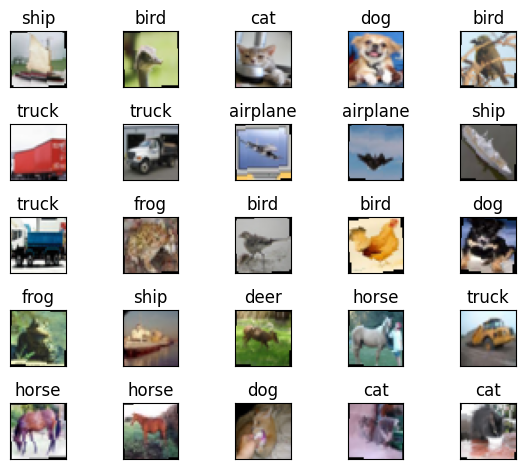

In [6]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Define plotting functions

In [ ]:
import matplotlib.pyplot as plt
def show_incorrect_predictions(incorrect_predictions, class_names, num_rows = 5, num_cols = 5):
    cnt = 0
    num_images_to_preview = num_rows*num_cols
    fig = plt.figure(figsize=(num_rows*10, num_cols*10))
    for this_pred in incorrect_predictions:
        orig_img = this_pred[0]
        target_label = this_pred[1]
        predicted_label = this_pred[2]
        output_label = this_pred[3]
        ax = fig.add_subplot(num_rows, num_cols, cnt+1,xticks=[],yticks=[])
        #plt.subplot(num_rows,num_cols,cnt+1)
        this_img = np.asarray(orig_img)
        plt.imshow(this_img.transpose((1,2,0)))
        #title_str = f"{class_names[str(target_label.item())]}/{class_names[str(predicted_label.item())]}"
        title_str = f"{class_names[str(target_label.item())]}/{class_names[str(predicted_label.item())]}"
        ax.set_title(title_str)
        cnt+=1
        if cnt == num_images_to_preview:
            break
    plt.show()


def plot_statistics(train_losses, train_acc, test_losses, test_acc, target_test_acc = 99):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].axhline(target_test_acc, color='r')
    axs[1, 1].set_title("Test Accuracy")

Train model using Batch Normalization

In [ ]:
model_bn = Model_Net(norm_type='batch_norm').to(device)
optimizer = optim.SGD(model_bn.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, verbose=True)
train_losses_bn = []
test_losses_bn = []
train_acc_bn = []
test_acc_bn = []
for epoch in range(1,20):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(model_bn, device, train_loader, optimizer, train_acc_bn, train_losses_bn)
    this_loss = model_test(model_bn, device, test_loader, test_acc_bn, test_losses_bn)
    scheduler.step()
target_test_acc = 70.


Plot results for Batch Norm experiment

In [ ]:
#plot_statistics(train_losses_bn, train_acc_bn, test_losses_bn, test_acc_bn, target_test_acc)
#incorrect_predictions_bn = get_incorrect_predictions(model_bn, test_loader, device)
#show_incorrect_predictions(incorrect_predictions_bn, class_names, num_rows = 2, num_cols = 5)

Train Model using Layer Normalization

In [ ]:
model_ln = Model_Net(norm_type='layer_norm').to(device)
optimizer_ln = optim.SGD(model_ln.parameters(), lr=0.01, momentum=0.9)
scheduler_ln = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ln, mode='min', factor=0.1, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
train_losses_ln = []
test_losses_ln = []
train_acc_ln = []
test_acc_ln = []
for epoch in range(1,20):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(model_ln, device, train_loader, optimizer_ln, train_acc_ln, train_losses_ln)
    this_loss = model_test(model_ln, device, test_loader, test_acc_ln, test_losses_ln)
    scheduler_ln.step(this_loss)
target_test_acc = 70.



Show Results for Layer Norm experiments

In [ ]:
#plot_statistics(train_losses_ln, train_acc_ln, test_losses_ln, test_acc_ln, target_test_acc)
#incorrect_predictions_ln = get_incorrect_predictions(model_ln, test_loader, device)
#show_incorrect_predictions(incorrect_predictions_ln, class_names, num_rows = 2, num_cols = 5)

Train Model using Group Normalization

In [ ]:
model_gn = Model_Net(norm_type='group_norm', num_groups=2).to(device)
optimizer_gn = optim.SGD(model_gn.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer_gn, step_size=8, gamma=0.1, verbose=True)
train_losses_gn = []
test_losses_gn = []
train_acc_gn = []
test_acc_gn = []
for epoch in range(1,20):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(model_gn, device, train_loader, optimizer_gn, train_acc_gn, train_losses_gn)
    this_loss = model_test(model_gn, device, test_loader, test_acc_gn, test_losses_gn)
    scheduler.step()
target_test_acc = 70.



Plot Results for Group Norm

In [ ]:
#plot_statistics(train_losses_gn, train_acc_gn, test_losses_gn, test_acc_gn, target_test_acc)
#incorrect_predictions_ln = get_incorrect_predictions(model_gn, test_loader, device)
#show_incorrect_predictions(incorrect_predictions_gn, class_names, num_rows = 2, num_cols = 5)